# The Bernstein-Vazirani algorithm
**The problem:** an oracle (i.e. a black box) is given that encodes a secret number (in the form of an $n$-bit bitstring).
Every call to the oracle outputs just one bit: the dot-product (mod 2) of the input and the secret.

$$f(x) = x.s \pmod{2}$$

**Solution:**
Classically, we need to make at least $n$ queries to the oracle to find the secret (one strategy is to send inputs $\overline{0\dots01}$, $\overline{0\dots10}$, $\dots$, $\overline{1\dots00}$. Then every output reveals one positional bit).

However, when the oracle is given as a _quantum_ black box, the secret can be recovered fully with just **1 query**. This result is known as the [Bernstein-Vazirani algorithm](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.655.1186&rep=rep1&type=pdf) (see Sections 8.3 & 8.4 of link). 

**Intuition:**
Classically, we cannot recover $n$ bits of information faster than in $n$ steps, because every step outputs just 1 bit. This is the information-theoretic bound.
But in the quantum setting, the oracle can receive a superposition of queries, and return a superposition of answers. If we send the right superposition query, and use quantum interference to filter the superposition answers, we can obtain the correct answer with a single query.

This notebook is an implementation of this algorithm in _QISKit_ (The Quantum Information Software Kit).

## 1. Setting up the oracle

We first have to implement a quantum version of the oracle. Since every quantum computation is reversible, the above function must be modified to become reversible, yet still produce the dot-product in some way.

One way to do this would be to use the canonical method for embedding non-reversible circuits into reversible ones, first proposed by [Charles Bennett in 1973](https://www.math.ucsd.edu/~sbuss/CourseWeb/Math268_2013W/Bennett_Reversibiity.pdf):

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$f(\ket{x}\ket{tmp}) = \ket{x}\ket{x.s \oplus tmp}$$

Here, a _tmp_ qubit is introduced to hold the result of the dot-product. So the new function, instead of mapping $\{0,1\}^n\to\{0,1\}$, maps $\{0,1\}^{(n+1)}\to\{0,1\}^{(n+1)}$, and is reversible.

But this is not the only way for writing a dot-product oracle function. [Du et al.](https://arxiv.org/pdf/quant-ph/0012114.pdf) introduce a method for a simpler oracle that does not require an extra qubit. 

$$f(\ket{x}) = \ket{(-1)^{x.s} x}$$

The difference is that now the input changes by the oracle, whereas in the above, the input remained intact.

In both cases, the solution is found by using the oracle to _simultaneously encode the secret in the phases of the superposition input_. In the first case, this is achieved using [phase-kickback](https://www.quora.com/What-is-phase-kickback-and-how-does-it-occur) from the _tmp_ qubit to input register $\ket{x}$. In the second case, the phases are encoded directly.

In [39]:
# Specify available resources
num_qubits = int(input("How many bits in the oracle? "))

How many bits in the oracle? 5


In [40]:
# Hide the secret in the Oracle
s = int(input("Oracle's secret number (in decimal): "))
if s >= pow(2,num_qubits) or s < 0:
    raise ValueError("Cannot represent number "
                     "with available Oracle bits.")
print("Oracle is hiding these", num_qubits, "bits: ", 
      "{0:0{1}b}".format(s,num_qubits))

Oracle's secret number (in decimal): 6
Oracle is hiding these 5 bits:  00110


In [44]:
oracle_structure = input("Oracle structure to use ['bennett', 'du']: ")

Oracle structure to use ['bennett', 'du']: du


In [45]:
# specify quantum & classical register on the quantum computer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
q = QuantumRegister('q', num_qubits)
tmp = QuantumRegister('tmp', 1)
res = ClassicalRegister('res', num_qubits)

In [46]:
# build an oracle that acts on these registers with the given secret
if (oracle_structure == 'bennett'):
    oracle = QuantumCircuit(q, tmp, res)
    for i in range(len(q)):
        if (s & (1 << i)):
            oracle.cx(q[i], tmp[0])
elif (oracle_structure == 'du'):
    oracle = QuantumCircuit(q, res)
    for i in range(len(q)):
        if (s & (1 << i)):
            oracle.z(q[i])
else:
    raise ValueError('Unknown Oracle structure')

In [47]:
# verify the oracle has the correct CNOT pattern
print(oracle.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg res[5];
z q[1];
z q[2];



## 2. Solving the problem

In [50]:
# build the solution circuit
if (oracle_structure == 'bennett'):
    bv = QuantumCircuit(q, tmp, res)
    bv.x(tmp[0])
    bv.h(q)
    bv.h(tmp)
    bv += oracle # make a single oracle query
    bv.h(q)
    bv.h(tmp)
    bv.barrier(q)
    bv.measure(q, res)
if (oracle_structure == 'du'):
    bv = QuantumCircuit(q, res)
    bv.h(q)
    bv += oracle # make a single oracle query
    bv.h(q)
    bv.barrier(q)
    bv.measure(q, res)

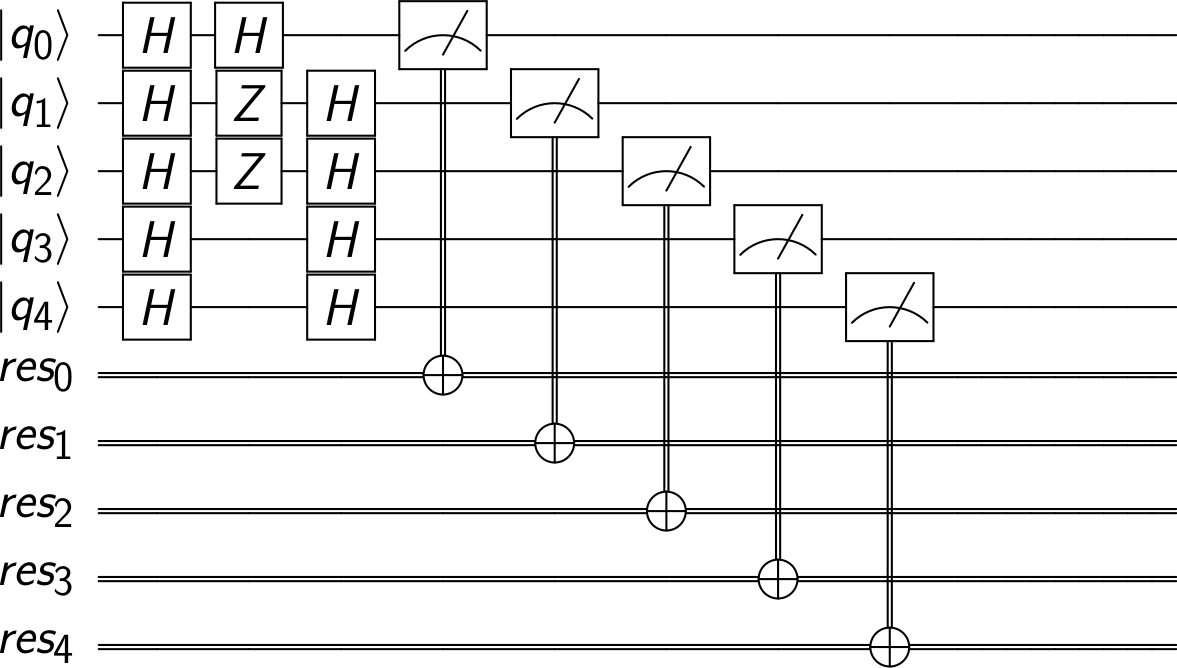

In [51]:
# verify the circuit is as expected
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(bv)

## 3. Executing the circuit

In [52]:
# wrap the QuantumCircuit in a QuantumProgram
from qiskit import QuantumProgram
qp = QuantumProgram()
qp.add_circuit('bv', bv)

### 3.a - Get information about backends

In [53]:
# set up API to access remote backends (e.g. real devices)
import Qconfig
qp.set_api(Qconfig.APItoken, Qconfig.config['url'])

In [54]:
# see all available backends (local & remote)
from qiskit import backends
print(backends.local_backends())
print(backends.remote_backends())

['local_projectq_simulator', 'local_qasm_simulator', 'local_unitary_simulator']
['ibmqx5', 'ibmqx4', 'ibmqx_hpc_qasm_simulator', 'ibmqx2', 'ibmqx_qasm_simulator']


In [55]:
# get current status of real devices
for device in backends.remote_backends():
    print(device)
    print(qp.get_backend_status(device))

ibmqx5
{'available': False, 'busy': False, 'pending_jobs': 31, 'backend': 'ibmqx5'}
ibmqx4
{'available': True, 'busy': False, 'pending_jobs': 0, 'backend': 'ibmqx4'}
ibmqx_hpc_qasm_simulator
{'backend': 'ibmqx_hpc_qasm_simulator'}
ibmqx2
{'available': True, 'busy': False, 'pending_jobs': 0, 'backend': 'ibmqx2'}
ibmqx_qasm_simulator
{'available': True, 'busy': False, 'pending_jobs': 0, 'backend': 'ibmqx_qasm_simulator'}


### 3.b - Execute on a local simulator and a real device

In [56]:
# setup execution parameters
circuit_list_to_execute = ['bv']
simulator_backend = 'local_qasm_simulator'
real_backend = 'ibmqx2'
timeout = 900 # (seconds)

In [57]:
# simulator run
result_ideal = qp.execute(circuit_list_to_execute, 
                          backend=simulator_backend,
                          shots=1, timeout=timeout)
print(result_ideal)

COMPLETED


In [58]:
# real run
result_real = qp.execute(circuit_list_to_execute, 
                         backend=real_backend,
                         shots=1000, timeout=timeout)
print(result_real)

COMPLETED


### 3.c - Report results

In [59]:
from qiskit.tools.visualization import plot_histogram
counts_ideal = result_ideal.get_counts('bv')
counts_real = result_real.get_counts('bv')
print(counts_real)

{'10000': 1, '10010': 1, '10100': 3, '10101': 6, '10110': 2, '10111': 5, '11100': 1, '00000': 12, '00001': 8, '00010': 9, '00011': 7, '00100': 220, '00101': 218, '00110': 226, '00111': 256, '01010': 1, '01100': 2, '01101': 6, '01110': 8, '01111': 8}


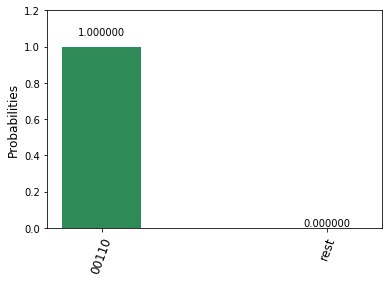

In [60]:
plot_histogram(counts_ideal, number_to_keep=8)

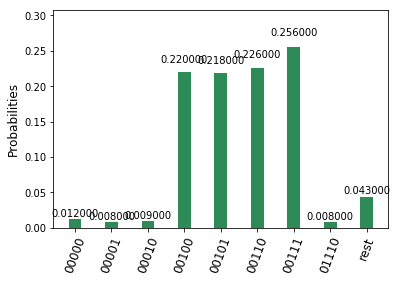

In [61]:
plot_histogram(counts_real, number_to_keep=8)